In [1]:
import pandas as pd
import subprocess 

load_new = False

if load_new:
    print('Download data:')
    subprocess.call(['wget', '-O', 'data.csv', 'http://cowid.netlify.com/data/full_data.csv'])

data = pd.read_csv('data.csv')
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d') #, data.dtypes

data.head()

,date,location,new_cases,new_deaths,total_cases,total_deaths
0,2020-02-25,Afghanistan,NaN,NaN,1,NaN
1,2020-02-26,Afghanistan,0.0,NaN,1,NaN
2,2020-02-27,Afghanistan,0.0,NaN,1,NaN
3,2020-02-28,Afghanistan,0.0,NaN,1,NaN
4,2020-02-29,Afghanistan,0.0,NaN,1,NaN


In [2]:
data.dtypes

date            datetime64[ns]
location                object
new_cases              float64
new_deaths             float64
total_cases              int64
total_deaths           float64
dtype: object

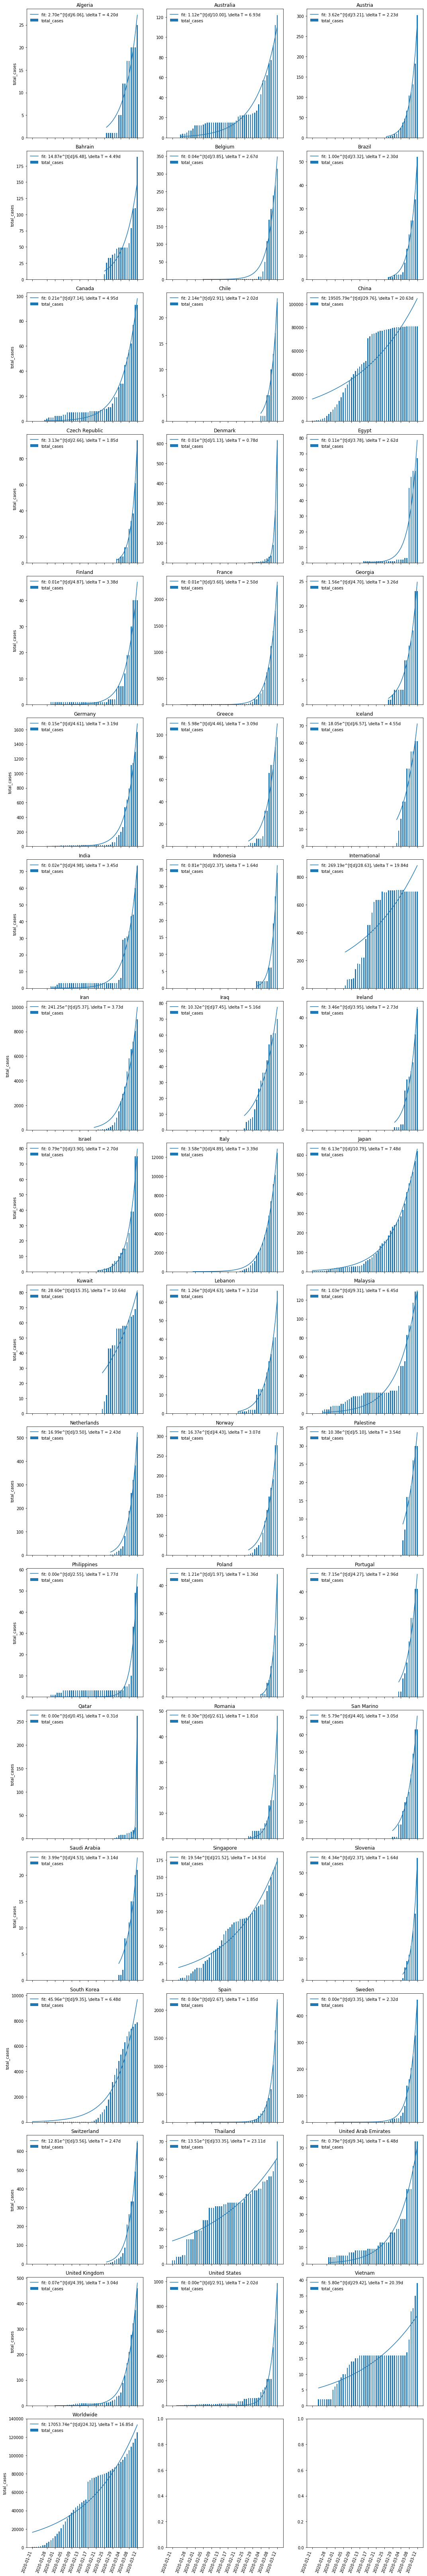

In [10]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import datetime 
import numpy as np

def set_ticks(times, ax):
    tickevery = 4
    #ticks = list(map(lambda x: x.strftime("%d %b"), times))[::tickevery]
    
    ticks = np.datetime_as_string(times, unit='D')[::tickevery]
    
    ax.set_xticks(times[::tickevery])
    ax.set_xticklabels(ticks, rotation = 70, ha="right")
    
def plot_bar_datetime(times, y, ax, label = None, title = None):
    
    ax.bar(times, y, width = .5, label = label)
        

def fit_exp(times, y, first_case_date):
    
    def exp_f_(times_, a, R):
        return a*np.exp(times_/R)
    
    
    #times_ = (times - np.datetime64('2020-02-01'))/np.timedelta64(1, 'D')
    times_ = (times - first_case_date - np.timedelta64(1, 'D'))/np.timedelta64(1, 'D')
    
    a, R = curve_fit(exp_f_, times_, y, [3, 3])[0]
    
    return exp_f_(times_, a, R), a, R
    
def plot_line_datetime(times, y, ax, label = None, title = None):
    
    ax.plot(times, y, label = label)
    

def plot_fig1(mask, title, ax):
    times = data.loc[mask, 'date'].values.astype('datetime64[D]')
    y = data.loc[mask, y_key].values


    y = np.nan_to_num(y)

    plot_bar_datetime(times, y, ax, y_key, 'Finland')
    
    
    y_fit, a, R = fit_exp(times, y, times[y != 0][0])

    label = r'fit: {:.02f}e^[t[d]/{:.02f}], \delta T = {:.02f}d'.format(a, R, np.log(2)*R)
    plot_line_datetime(times, y_fit, ax, label, 'Finland')

    
    if title is not None: ax.set_title(title)
    if label is not None: ax.legend(frameon = False)


y_key = 'total_cases'    

countries = sorted([country for country in data.location.unique() if data.loc[data.loc[:, 'location'] == country, 'total_cases'].max() > 20])

ncols = 3
nrows = len(countries)//ncols + 1

figW, figH = ncols * 5, nrows*5
fig, axarr = plt.subplots(nrows,ncols, figsize = (figW, figH), sharex = True)

for country, ax in zip(countries, axarr.ravel()):
    mask = data.location == country
    plot_fig1(mask, country, ax)

times = data.loc[:, 'date'].unique().astype('datetime64[D]')   

    
for i in range(len(axarr)): axarr[i,0].set_ylabel(y_key)
for i in range(len(axarr[0])): set_ticks(times, axarr[-1, i])

plt.tight_layout()
plt.savefig('countries.pdf', facecolor=fig.get_facecolor(), transparent=True)
plt.show()